## Week 6 Homework - Treatment for Malocclusion 

In this assignment you are going to analyse scull measurement data of patients with malocclusion.

Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:

- Treatment: untreated (0) or treated (1).
- Growth: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA.
- ANB: angle between Down's points A and B (degrees).
- IMPA: incisor-mandibular plane angle (degrees).
- PPPM: palatal plane - mandibular plane angle (degrees).
- CoA: total maxillary length from condilion to Down's point A (mm).
- GoPg: length of mandibular body from gonion to pogonion (mm).
- CoGo: length of mandibular ramus from condilion to pogonion (mm).

All the measurements are taken from x-ray scans using a set of reference points established using a map like the following:

![reference-points](reference-points.png "reference-points")

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements.

We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. Our knowledge of those causal relationships is represented on the following DAG:

![causal_model](causal_model.png "causal_model")

Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows. 

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.

The dataset is taken from Scutari, M., Auconi, P., Caldarelli, G., Franchi, L. (2017) Bayesian Networks Analysis of Malocclusion Data. Scientific Reports , 7, 15236.

### REVIEW CRITERIA

Your analysis should contain:

- Selection of covariates to adjust for (informed by the  graph)
- Application of the most suitable adjustment method
- Estimates of the ATE and ATET

## Solution

In [1]:
import statsmodels
import pandas as pd
import scipy as sc
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('malocclusion.csv')
data.head(5)

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0


array([[<AxesSubplot:xlabel='dANB', ylabel='dANB'>,
        <AxesSubplot:xlabel='dPPPM', ylabel='dANB'>,
        <AxesSubplot:xlabel='dIMPA', ylabel='dANB'>,
        <AxesSubplot:xlabel='dCoA', ylabel='dANB'>,
        <AxesSubplot:xlabel='dGoPg', ylabel='dANB'>,
        <AxesSubplot:xlabel='dCoGo', ylabel='dANB'>,
        <AxesSubplot:xlabel='dT', ylabel='dANB'>],
       [<AxesSubplot:xlabel='dANB', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dPPPM', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dIMPA', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dCoA', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dGoPg', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dCoGo', ylabel='dPPPM'>,
        <AxesSubplot:xlabel='dT', ylabel='dPPPM'>],
       [<AxesSubplot:xlabel='dANB', ylabel='dIMPA'>,
        <AxesSubplot:xlabel='dPPPM', ylabel='dIMPA'>,
        <AxesSubplot:xlabel='dIMPA', ylabel='dIMPA'>,
        <AxesSubplot:xlabel='dCoA', ylabel='dIMPA'>,
        <AxesSubplot:xlabel='dGoPg', ylabel='

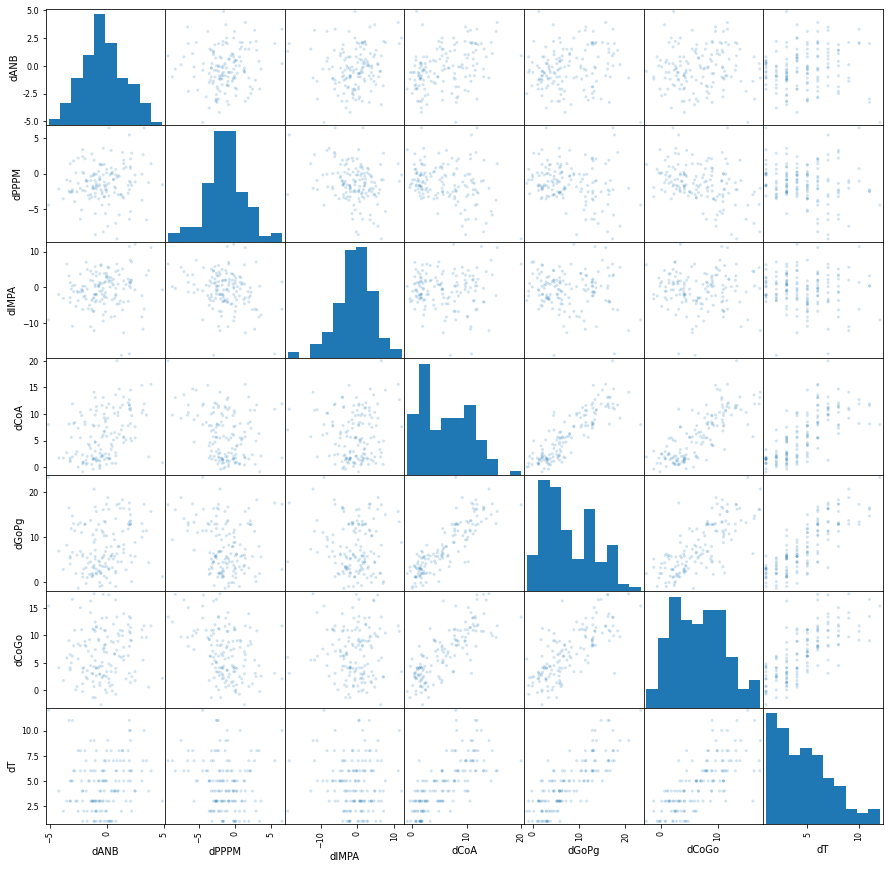

In [93]:
pd.plotting.scatter_matrix(data[['dANB', 'dPPPM', 'dIMPA', 'dCoA', 'dGoPg', 'dCoGo', 'dT']], \
                                alpha=0.2, figsize=(15, 15), diagonal='hist')

### Снала будем оценивать effect of the treatment on Growth

Let's estimate balance of the sample. We see that for each feature, all meanings are encountered often - everything ok.

In [3]:
data['Growth'].value_counts()

0    85
1    58
Name: Growth, dtype: int64

In [4]:
data['Treatment'].value_counts()

0    77
1    66
Name: Treatment, dtype: int64

### Building the model

Let's build a linear model for all the features we have.

Growth - we will predict.

In [12]:
m = smf.ols('Growth ~ dANB + dPPPM + dIMPA + dCoA + dGoPg + dCoGo + dT + Treatment', data=data)
fitted = m.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     9.199
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           4.84e-10
Time:                        20:25:16   Log-Likelihood:                -69.894
No. Observations:                 143   AIC:                             157.8
Df Residuals:                     134   BIC:                             184.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5174      0.076      6.804      0.0

We should have drawn the DAG before trying to estimate ATE.

![dag-growth](dag-growth.png "dag growth")

With the DAG of the problem it's clear now that we only have to adjust for dT. Let's see what we'd get:

In [6]:
m = smf.ols('Growth ~ dT + Treatment', data=data)
fitted = m.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.433
Date:                Tue, 23 Mar 2021   Prob (F-statistic):             0.0350
Time:                        20:17:07   Log-Likelihood:                -97.770
No. Observations:                 143   AIC:                             201.5
Df Residuals:                     140   BIC:                             210.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4623      0.086      5.382      0.0

### Propensity score weighting

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# classifier to estimate the propensity score
cls = LogisticRegression()

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = data[['Growth']]
y = data['Treatment']
cls.fit(X, y)
data['e'] = cls.predict_proba(X)[:,1].tolist()
data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.34318
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.42124
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.34318
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.34318
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.34318


### Propensity score matching

In [10]:
from causalinference import CausalModel

causal = CausalModel(
    Y=data['Growth'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data['e'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.000      0.000     -3.817      0.000     -0.000     -0.000
           ATC      0.000      0.000      0.000      1.000     -0.000      0.000
           ATT     -0.000      0.000     -8.374      0.000     -0.000     -0.000



/Library/Python/3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


ATE and ATET are equals to zero as Treatment does not affect Growth at all.

### Now we will evaluate the effect of the treatment on dANB

Similar, firstly I will draw the DAG before trying to estimate ATE.

![dag-danb](dag-danb.png "dag danb")

With the DAG of the problem it's clear now that we only have to adjust for dT, Growth, dCOA, dCoGo, dPPM, dIPPA. Let's see what we'd get:

In [13]:
m = smf.ols('dANB ~ Growth + dPPPM + dIMPA + dCoA + dCoGo + dT + Treatment', data=data)
fitted = m.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     21.83
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           1.64e-19
Time:                        20:26:05   Log-Likelihood:                -234.40
No. Observations:                 143   AIC:                             484.8
Df Residuals:                     135   BIC:                             508.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1044      0.261     -4.234      0.0

### Propensity score weighting

In [15]:
cls = LogisticRegression()
cls = CalibratedClassifierCV(cls)

X = data[['dANB']]
y = data['Treatment']

cls.fit(X, y)
data['e'] = cls.predict_proba(X)[:,1].tolist()
data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.089907
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.382762
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.223367
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.295665
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.295665


In [16]:
data['w'] = data['Treatment'] / data['e'] + (1 - data['Treatment']) / (1 - data['e'])
data['w_att'] = data['Treatment'] + data['e'] * (1 - data['Treatment']) / (1 - data['e'])

In [17]:
m = smf.wls('dANB ~ Growth + dPPPM + dIMPA + dCoA + dCoGo + dT + Treatment', data=data, weights=data['w'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.259
Model:                            WLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     6.739
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           7.47e-07
Time:                        20:35:15   Log-Likelihood:                -299.36
No. Observations:                 143   AIC:                             614.7
Df Residuals:                     135   BIC:                             638.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8178      0.412     -1.983      0.0

### ATE = 1.8994

In [18]:
m = smf.wls('dANB ~ Growth + dPPPM + dIMPA + dCoA + dCoGo + dT + Treatment', data=data, weights=data['w_att'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.252
Model:                            WLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     6.486
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           1.35e-06
Time:                        20:35:44   Log-Likelihood:                -318.85
No. Observations:                 143   AIC:                             653.7
Df Residuals:                     135   BIC:                             677.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0029      0.453      0.006      0.9

### ATET = 1.8051